In [ ]:
#  TCGA dataset
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn.functional as F
import numpy as np
import pandas as pd
import torchvision
from torchvision import models, datasets
from torchvision.transforms import transforms
from torch.utils.data import WeightedRandomSampler, DataLoader, SubsetRandomSampler, Subset
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
import os
import shutil
from PIL import Image
import matplotlib.pyplot as plt
import random
import matplotlib.pyplot as plt
from torchsummary import summary
import numpy as np
import cv2 as cv
torch.manual_seed(0)
torch.cuda.manual_seed(0)
# %matplotlib inline
random.seed(0)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
os.listdir("/content/drive/MyDrive/Furniture Images/furniture_images")

[]

In [ ]:
from google.colab import files
files.upload() #upload kaggle.json

!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
kaggle.json


In [ ]:
!kaggle datasets download -d lasaljaywardena/furniture-images-dataset

 87% 33.0M/38.1M [00:02<00:00, 18.4MB/s]
100% 38.1M/38.1M [00:02<00:00, 17.4MB/s]


In [ ]:
!unzip furniture-images-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: furniture_images/furniture_images/1634020998420_Portable Folding Laptop Table for sale.jpg  
  inflating: furniture_images/furniture_images/1634020998618_King Bed Double Comforter Set for sale.jpg  
  inflating: furniture_images/furniture_images/1634020998789_sofa set wood for sale.jpg  
  inflating: furniture_images/furniture_images/1634020998992_Writing Table W Cupboard 42 for sale.jpg  
  inflating: furniture_images/furniture_images/1634020999351_2 Door Melamine OC Cupboard for sale.jpg  
  inflating: furniture_images/furniture_images/1634020999716_Black Oc Cupboard 2 Door for sale.jpg  
  inflating: furniture_images/furniture_images/1634021000049_Steel Cupboard 6 BY 4 for sale.jpg  
  inflating: furniture_images/furniture_images/1634021000327_MELAMINE O C CUPBOARD for sale.jpg  
  inflating: furniture_images/furniture_images/1634021000692_Teak Box Bed 6 by 4 with Piyestra 5 Layer Hybrid Mattress for sale.jpg  
  inflat

In [ ]:
len(os.listdir("/content/furniture_images/furniture_images"))

9277

In [ ]:
batch_size = 512
input_size = 64
num_epochs = 100
learning_rate = 0.0005
warm_restart = 12
weight_decay = 0.00001

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [ ]:
transform_train = transforms.Compose([transforms.ToTensor(),
                                transforms.Grayscale(num_output_channels=1),
                                transforms.RandomHorizontalFlip(p=0.5),
                                transforms.RandomVerticalFlip(p=0.5),
                                transforms.RandomRotation(degrees=30),
                                transforms.RandomChoice([
                                    transforms.Pad(padding=10),
                                    transforms.CenterCrop((60,60)),
                                    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1)]),
                                transforms.Resize([input_size, input_size]),
                                ])
transform_test = transforms.Compose([transforms.ToTensor(),
                                transforms.Grayscale(num_output_channels=1),
                                transforms.RandomHorizontalFlip(p=0.5),
                                transforms.RandomVerticalFlip(p=0.5),
                                transforms.RandomRotation(degrees=30),
                                transforms.RandomChoice([
                                    transforms.Pad(padding=10),
                                    transforms.CenterCrop((60,60)),
                                    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1)]),
                                transforms.Resize([input_size, input_size]),
                                ])

In [ ]:
full_dataset = datasets.ImageFolder("/content/furniture_images",transform=transform_train)
full_data_size = len(full_dataset)

In [ ]:
train_size = int(0.9 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])

In [ ]:
test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=2)
train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=2)

In [ ]:
count = 0
for i in full_dataset:
  count+=1
print("total images=", count)
count = 0
for i in train_dataset:
  count+=1
print("train images=", count)
count = 0
for i in test_dataset:
  count+=1
print("test images=", count)

KeyboardInterrupt: ignored

In [ ]:
for i in train_dataset:
  img = i[0]
  break

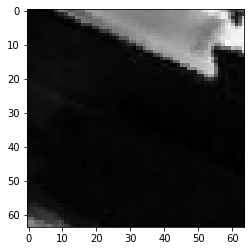

In [ ]:
plt.imshow(np.array(img.permute(1,2,0)).reshape(input_size, input_size), cmap="gray")

In [ ]:
input_size*input_size

4096

In [ ]:
class Model(nn.Module):
  def __init__(self, input_dim, output_dim):
    super().__init__()
    self.input_dim = input_dim
    self.output_dim = output_dim
    self.fc0 = nn.Linear(input_dim, input_dim//4)
    self.fc1 = nn.Linear(input_dim//4, input_dim//16)
    self.batchnorm1 = nn.BatchNorm1d(input_dim//16)
    self.fc2 = nn.Linear(input_dim//16, input_dim//32)
    self.fc3 = nn.Linear(input_dim//32, input_dim//128)
    self.batchnorm2 = nn.BatchNorm1d(input_dim//128)
    self.fc4 = nn.Linear(input_dim//128, input_dim//32)
    self.fc5 = nn.Linear(input_dim//32, input_dim//16)
    self.batchnorm3 = nn.BatchNorm1d(input_dim//16)
    self.fc6 = nn.Linear(input_dim//16, input_dim//4)
    self.fc7 = nn.Linear(input_dim//4, input_dim)
    self.relu = nn.ReLU()
  
  def forward(self, x):
    x = self.relu(self.fc0(x))
    x = self.relu(self.batchnorm1(self.fc1(x)))
    x = self.relu(self.fc2(x))
    x = self.relu(self.batchnorm2(self.fc3(x)))
    x = self.relu(self.fc4(x))
    x = self.relu(self.batchnorm3(self.fc5(x)))
    x = self.relu(self.fc6(x))
    x = self.fc7(x)
    return(x)

In [ ]:
model = Model(input_size*input_size, input_size*input_size)

In [ ]:
model.to(device)

Model(
  (fc0): Linear(in_features=4096, out_features=1024, bias=True)
  (fc1): Linear(in_features=1024, out_features=256, bias=True)
  (batchnorm1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=32, bias=True)
  (batchnorm2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc4): Linear(in_features=32, out_features=128, bias=True)
  (fc5): Linear(in_features=128, out_features=256, bias=True)
  (batchnorm3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc6): Linear(in_features=256, out_features=1024, bias=True)
  (fc7): Linear(in_features=1024, out_features=4096, bias=True)
  (relu): ReLU()
)

In [ ]:
def count_parameters(Model): 
  return sum(p.numel() for p in Model.parameters() if p.requires_grad), sum(p.numel() for p in Model.parameters())
print(count_parameters(model))

(8994656, 8994656)


In [ ]:
criterion = nn.MSELoss().cuda()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# schedular = CosineAnnealingWarmRestarts(optimizer,warm_restart)
criterion.to(device)

MSELoss()

In [ ]:
num_batches = len(train_loader)

In [ ]:
def get_sobel(inputs):
  sobel = [[1, 2, 1], [0, 0, 0], [-1, -2, -1]]
  sobel_kernel = torch.tensor(sobel, dtype=torch.float32).expand(inputs.size()[1], inputs.size()[1], 3, 3).to(device)
  return(sobel_kernel)
def get_previt(inputs):
  previt = [[1, 1, 1], [0, 0, 0], [-1, -1, -1]]
  previt_kernel = torch.tensor(previt, dtype=torch.float32).expand(inputs.size()[1], inputs.size()[1], 3, 3).to(device)
  return(previt_kernel)
def get_laplacian(inputs):
  laplacian = [[-1,-1,-1],[-1,8,-1],[-1,-1,-1]]
  laplacian_kernel = torch.tensor(laplacian, dtype=torch.float32).expand(inputs.size()[1], inputs.size()[1], 3, 3).to(device)
  return(laplacian_kernel)

In [ ]:
def getTestLoss(test_loader, model):
  loss_list = []
  model.eval()
  for i, data in enumerate(train_loader, 0):
    inputs = data[0].to(device)
    kernel = get_laplacian(inputs)
    # inputs = inputs.squeeze(1)
    labels = data[1].to(device)
    inputs = inputs - torch.min(inputs)
    inputs = inputs/torch.max(inputs)
    inputs2 = inputs.reshape([-1, 4096])
    target = F.conv2d(inputs, kernel, padding=1)
    target = target - torch.min(target)
    target = target/torch.max(target)
    target = target.reshape([-1, 4096])
    outputs = model(inputs2)
    loss = criterion(outputs, target)
    loss_list.append(loss.item())
  model.train()
  return(np.mean(loss_list))

In [ ]:
loss_list = []
testLossList = []
for epoch in range(num_epochs):  # loop over the dataset multiple times
    itr = 0
    itr_str = ""
    l = 0
    batch_loss_list = []
    # lr = schedular.get_last_lr()
    lr = learning_rate
    print("| Epoch: {} | Learning Rate={}".format(epoch, lr))
    for i, data in enumerate(train_loader, 0):
      print("\r",end="")
      print("loss={} {}/{} :{}".format(l,itr,num_batches,itr_str),end="")
      if i%5==0:
        itr_str+="."
      # get the inputs; data is a list of [inputs, labels]
      # After adding sampler, labels became int
      
      inputs = data[0].to(device)
      kernel = get_laplacian(inputs)
      # inputs = inputs.squeeze(1)
      labels = data[1].to(device)
      inputs = inputs - torch.min(inputs)
      inputs = inputs/torch.max(inputs)
      inputs2 = inputs.reshape([-1, 4096])
      target = F.conv2d(inputs, kernel, padding=1)
      target = target - torch.min(target)
      target = target/torch.max(target) 
      target = target.reshape([-1, 4096])
            
      # zero the parameter gradients
      optimizer.zero_grad()
      model.zero_grad()
      # forward + backward + optimize
      outputs = model(inputs2)
      loss = criterion(outputs, target)
      loss.backward()
      optimizer.step()
      # schedular.step(epoch + i / num_batches)

      itr+=1
      # print statistics
      l = loss.item()
      batch_loss_list.append(l)
    loss_list.append(batch_loss_list)
    l2 = getTestLoss(test_loader, model)
    testLossList.append(l2)
    print("test loss=",l2)

| Epoch: 0 | Learning Rate=0.0005
loss=0.010430275462567806 16/17 :....test loss= 0.14268769236171946
| Epoch: 1 | Learning Rate=0.0005
loss=0.005611076485365629 16/17 :....test loss= 0.03448038241442512
| Epoch: 2 | Learning Rate=0.0005
loss=0.004076906479895115 16/17 :....test loss= 0.00953484173206722
| Epoch: 3 | Learning Rate=0.0005
loss=0.0030193726997822523 16/17 :....test loss= 0.002954568631727906
| Epoch: 4 | Learning Rate=0.0005
loss=0.0027259893249720335 16/17 :....test loss= 0.0029896856148672454
| Epoch: 5 | Learning Rate=0.0005
loss=0.004501127637922764 16/17 :....test loss= 0.003522994229570031
| Epoch: 6 | Learning Rate=0.0005
loss=0.002680886536836624 16/17 :....test loss= 0.003965567728942808
| Epoch: 7 | Learning Rate=0.0005
loss=0.0034461100585758686 16/17 :....test loss= 0.002866611665333895
| Epoch: 8 | Learning Rate=0.0005
loss=0.0031772051006555557 16/17 :....test loss= 0.0028346553033984758
| Epoch: 9 | Learning Rate=0.0005
loss=0.0027769310399889946 16/17 :..

In [ ]:
torch.save(model.state_dict(), "/content/drive/MyDrive/ML mini project/model7.pth")

In [ ]:
torch.save(model.state_dict(), "/content/drive/MyDrive/ML mini project/model6.pth")

In [ ]:
loss = [np.mean(i) for i in loss_list]

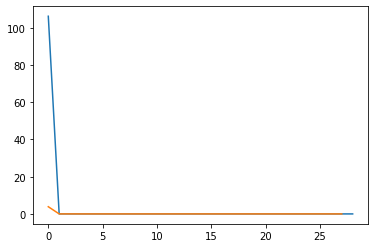

In [ ]:
plt.plot(loss)
plt.plot(testLossList)

In [ ]:
model.eval()
outputs = model(inputs2)
model.train()

Model(
  (fc0): Linear(in_features=4096, out_features=1024, bias=True)
  (fc1): Linear(in_features=1024, out_features=256, bias=True)
  (batchnorm1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=32, bias=True)
  (batchnorm2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc4): Linear(in_features=32, out_features=128, bias=True)
  (fc5): Linear(in_features=128, out_features=256, bias=True)
  (batchnorm3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc6): Linear(in_features=256, out_features=1024, bias=True)
  (fc7): Linear(in_features=1024, out_features=4096, bias=True)
  (relu): ReLU()
)

In [ ]:
opimg = outputs.reshape(-1,input_size,input_size)

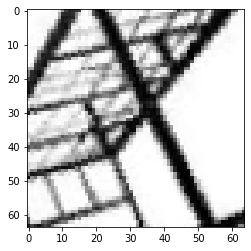

In [ ]:
plt.imshow(inputs[7].cpu().squeeze().detach().numpy(), cmap="gray")

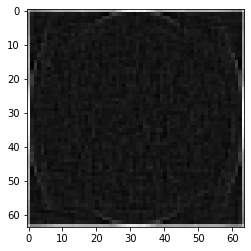

In [ ]:
plt.imshow(opimg[7].cpu().detach().numpy(), cmap="gray")